In [ ]:
#!pip install transformers
#!pip install sentencepiece
#!pip install seaborn

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd 
import numpy as np

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Sem6/SA_model_data")[['label','text']]
data

,label,text
0,0,join put phone talk rude take money acc willyn...
1,0,2 biggest fear incur std pregnancyi mean basic...
2,0,depress somebodi call long face still automat ...
3,0,grown adult drink never drank assum rais aroun...
4,0,offens peopl use cream build glutescom go squat
...,...,...
27995,6,dismal week
27996,6,hug yep hate meself
27997,6,serious need find laptop sometim get hot bbl e...
27998,6,awww hug wish could help


In [4]:
data.text.isnull().sum()

26

In [5]:
# drop 26 empty rows
data.dropna(inplace=True)

In [6]:
data.shape

(27974, 2)

explain,happy,sad,angry,confused,rq

happy -> "happiness", "love"

confused, explain -> "rq"

sad -> "sadness", "worry", "fear"

angry -> "anger"

In [7]:
classes = {
    0: 'angry',
    1: 'sad',
    2: 'happy',
    3: 'happy',
    4: 'explain',
    5: 'sad',
    6: 'sad'
}
def convertLabelToEmotion(row):
  return classes[row]
print(f'label to human label e.g. 0 is {convertLabelToEmotion(0)}')

label to human label e.g. 0 is angry


In [8]:
data['label'] = data['label'].apply(convertLabelToEmotion)

In [9]:
data

,label,text
0,angry,join put phone talk rude take money acc willyn...
1,angry,2 biggest fear incur std pregnancyi mean basic...
2,angry,depress somebodi call long face still automat ...
3,angry,grown adult drink never drank assum rais aroun...
4,angry,offens peopl use cream build glutescom go squat
...,...,...
27995,sad,dismal week
27996,sad,hug yep hate meself
27997,sad,serious need find laptop sometim get hot bbl e...
27998,sad,awww hug wish could help


In [10]:
# Import required libraries
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

In [11]:
train_data, test_data = train_test_split(data, test_size=0.20, random_state=42)

In [12]:
train_data

,label,text
21081,explain,salari make le matter mani hr work come territ...
15135,sad,worst day ever told chav
26113,sad,aww cannot believ wee girl bgt cri sad
19433,happy,fun see peopl side pond get right thank much s...
18777,happy,send ton thank love sock summit cannot believ ...
...,...,...
21585,explain,tweeti use yfrog think chanc ad client imag view
5392,sad,account poor first half start showboat game safe
860,angry,start think may need put big sign door tell le...
15798,sad,cannot feel lip numb burn


In [13]:
# Create a custom dataset class
class ProspectDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_mapping = { 'angry': 0,'sad': 1,'happy': 2,'explain': 3}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row["text"]
        label = row["label"]

        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            return_attention_mask=True,
            return_token_type_ids=False,
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "label": torch.tensor(self.label_mapping[label], dtype=torch.long),
        }

In [14]:
# Set up hyperparameters, tokenizer, and datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5
NUM_CLASSES = 4

In [15]:
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
train_dataset = ProspectDataset(train_data, tokenizer, MAX_LEN)
test_dataset = ProspectDataset(test_data, tokenizer, MAX_LEN)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
# Load the pre-trained model and fine-tune
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=NUM_CLASSES).to(device)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * EPOCHS)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [18]:
# Training loop
model.train()
print("Training:")
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_loss = 0.0
    for batch in tqdm(train_loader, desc="Batch", leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Average training loss: {avg_train_loss:.4f}")

Training:
Epoch 1/10


Average training loss: 1.0710
Epoch 2/10


Average training loss: 0.7632
Epoch 3/10


Average training loss: 0.6795
Epoch 4/10


Average training loss: 0.6132
Epoch 5/10


Average training loss: 0.5604
Epoch 6/10


Average training loss: 0.5003
Epoch 7/10


Average training loss: 0.4424
Epoch 8/10


Average training loss: 0.3934
Epoch 9/10


Average training loss: 0.3458
Epoch 10/10


Average training loss: 0.3137


In [19]:
# Model evaluation
model.eval()
print("\nTesting:")
predictions, true_labels = [], []
test_loss = 0.0
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Batch", leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        test_loss += loss.item()
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to("cpu").numpy()

        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)

avg_test_loss = test_loss / len(test_loader)
print(f"Average testing loss: {avg_test_loss:.4f}")


Testing:


Average testing loss: 0.9449


# Evaulation results

In [20]:
# Import required functions and libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

Classification Report:
              precision    recall  f1-score   support

       angry       0.74      0.74      0.74       791
         sad       0.76      0.76      0.76      2445
       happy       0.77      0.82      0.80      1539
     explain       0.47      0.40      0.43       820

    accuracy                           0.72      5595
   macro avg       0.68      0.68      0.68      5595
weighted avg       0.72      0.72      0.72      5595

Confusion Matrix:
[[ 587  142   27   35]
 [ 148 1869  187  241]
 [  22  160 1261   96]
 [  41  295  154  330]]


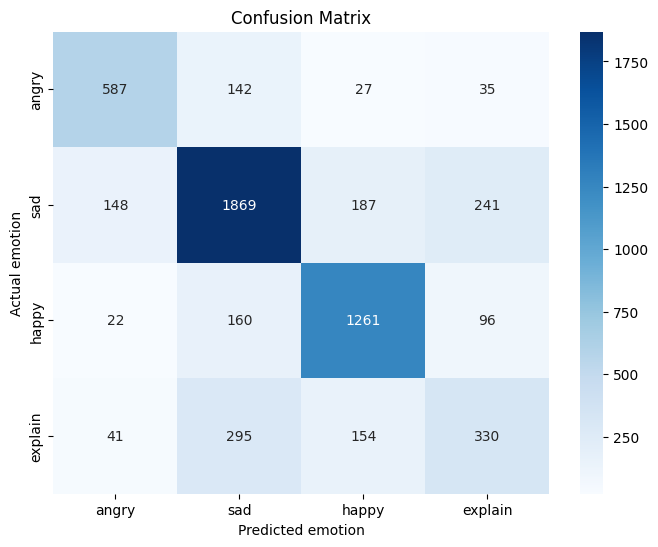

In [21]:
# Print classification report and confusion matrix
print("Classification Report:")
labels_in_order = ['angry','sad','happy','explain']
print(classification_report(true_labels, predictions, target_names=labels_in_order))

conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels_in_order, yticklabels=labels_in_order)
plt.title("Confusion Matrix")
plt.xlabel("Predicted emotion")
plt.ylabel("Actual emotion")
plt.show()

In [22]:
# Save the model and tokenizer
model.save_pretrained("/content/drive/MyDrive/Sem6/SA_model_i4")
tokenizer.save_pretrained("/content/drive/MyDrive/Sem6/SA_model_i4")

('/content/drive/MyDrive/Sem6/SA_model_i4/tokenizer_config.json',
 '/content/drive/MyDrive/Sem6/SA_model_i4/special_tokens_map.json',
 '/content/drive/MyDrive/Sem6/SA_model_i4/sentencepiece.bpe.model',
 '/content/drive/MyDrive/Sem6/SA_model_i4/added_tokens.json')

In [23]:
#!pip install transformers
#!pip install sentencepiece
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer
import torch

loaded_model = XLMRobertaForSequenceClassification.from_pretrained("/content/drive/MyDrive/Sem6/SA_model_i4")
loaded_tokenizer = XLMRobertaTokenizer.from_pretrained("/content/drive/MyDrive/Sem6/SA_model_i4")

labels_in_order = ['angry','sad','happy','explain']


def get_emotion(input_text):
  encoded_input = loaded_tokenizer.encode_plus(
      input_text,
      add_special_tokens=True,
      max_length=128,
      padding="max_length",
      truncation=True,
      return_tensors="pt")

  input_ids = encoded_input["input_ids"]
  attention_mask = encoded_input["attention_mask"]

  with torch.no_grad():
      logits = loaded_model(input_ids, attention_mask=attention_mask)
      
      # Optionally, you can apply softmax to obtain probabilities
      probabilities = torch.softmax(logits[0], dim=1)

  predicted_probabilities = probabilities[0]

  # Find the index of the class with the highest probability
  predicted_index = torch.argmax(predicted_probabilities).item()

  # Retrieve the predicted label based on the index
  predicted_label = labels_in_order[predicted_index]

  # Print the predicted label
  print("Predicted Label:", predicted_label)

In [25]:
get_emotion("I fucking hate this model!")

Predicted Label: angry
